# Performance énergétique des logements et niveau de vie des ménages en Ile-de-France¶

#### **Projet Python 2A ENSAE (année 2022-2023)**

#### Franki Nguimatsia Tiofak, Marc jodel Simo Noubissi, Gabriel Sklénard

## **Introduction**

### **Problématique:** 
 
Dans le contexte de la crise énergétique affectant un grand nombre de pays en 2022, il nous est apparu particulièrement intéressant d'étudier le lien entre performance énergétique des logements et niveau de vie des ménages. En effet, dans une période où la facture énergétique s'alourdit et atteint même des plus haut (en particulier pour le gaz), les ménages les plus défavorisés apparaissent plus vulnérables, et ce d'autant plus si leurs logements sont en moyenne plus énergivores que les ménages plus aisés. Notre projet Python cherche précisément à documenter cette vulnérabilité, avec notamment l'idée que la performance énergétique des logements ont un coût et bute nécessairement contre la contrainte budgétaire des ménages, mesurée ici par le niveau de vie médian au niveau de la commune. Qui plus est, un cercle vicieux pourrait s'instaurer: les ménages les moins aisés ont des difficultés à accéder à un logement économe en énergie, ce qui accroît la charge financière du logement et les appauvrit encore davantage. 

Pour avoir une volumétrie de données raisonnable, nous avons opté pour une approche géographique centrée sur l'Ile-de-France: il s'agit donc ici d'analyser la performance énergétique des logements franciliens en lien avec le niveau de vie mesuré dans chaque commune. La visualisation géographique pourrait contribuer à aider les décideurs publics à mieux cibler les éventuelles mesures de soutien à mettre en place pour atténuer le choc de la crise énergétique en Ile-de-France.

### **Principales étapes du projet:**
1. Récupération des données relatives aux diagnostics de performance énergétique (DPE) des logements franciliens (à partir de l'API de l'open data de l'ADEME.
2. Récupération des données de niveau de vie par commune à partir des fichiers de Filosofi 2016 disponibles sur Insee.fr
3. Retraitement des données.
4. Premières statistiques descriptives
5. Visualisations géographiques
6. Modélisation: quantification du rôle explicatif du niveau de vie médian de la commune sur: 
    a. la structure des logements par classe de consommation d'énergie; 
    b. le niveau moyen de consommation d'énergie par logement;
7. Principales limites et perspectives d'approfondissment

### **Principaux résultats et principales limites:**

#### Résulats de l'étude

1. Résultat 1: 
2. Résultat 2:
3. Résultat 3:

#### Limites de l'étude

1. Limite 1: les DPE observés dans chaque commune d'Ile-de-France ne résultent pas d'un échantillonage reposant sur un
plal de sondage garantissant la représentativité statistique des données à l'échelle de chaque commune. On ne dispose
en effet que d'une liste de DPE versés automatiquement dans la base de données de l'ADEME, dès lors qu'un diagnostic est validé numériquement. Par conséquent, on peut très bien imaginer que nos résultats sont affectés par des biais statistiques importants. Le nombre de DPE enregistrés dans une commune dépend du nombre de locations ou ventes de logements ayant eu lieu dans cette commune.
2. Limite 2:
3. Limite 3:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly
import re
import matplotlib
import plotly.express as px
import seaborn as sns

import sklearn
from sklearn.linear_model import Lasso
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import statsmodels.api as sm
import scipy
from scipy.stats import chi2_contingency as chi2_contingency
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error

Matplotlib is building the font cache; this may take a moment.


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)

import plotly
import plotly.express as px
from IPython.display import HTML #pour afficher les graphs
# dans une cellule de notebook

In [4]:
# Pour que les graphiques apparaissent dans le Notebook Jupyter:
%matplotlib inline

## **Importation des données retraitées**

In [5]:
pd.options.display.max_colwidth = 50

On importe les données récupérées et traitées dans le notebook récup&retraitement_données.ipynb:

In [6]:
# 1) Dataframe rassemblant tous les dpe réalisés dans les communes d'Ile-de-France (principales caractéristiques relatives 
# à la performance énergétique des logements):
# WARNING: pour lire ce csv, pensez à exécuter au préalable le notebook récup&retraitement_données.ipynb
# en effet le fichier dpe_IDF.csv est trop volumineux pour être stocké dans le repository Github "data_science_project"!
#dpe_idf = pd.read_csv("~/work/data_science_project/dpe_IDF.csv")

# 2) Dataframe rassemblant les communes d'IDF avec leur caractéristiques en terme de performance énergétique des logements
# ainsi que quelques données socio-économiques (Filosofi):
Filosofi_dpe_IDF_com= pd.read_csv("~/work/data_science_project/Filosofi_dpe_IDF_com.csv")

## **I) Analyse exploratoire des données et datavisualisation**

### **A)Analyse de la performance énergétique des logements à l'échelle des communes d'Ile-de-France:**

#### 1) Etape préliminaire: on exclut de l'analyse les communes pour lesquelles le nombre de DPE s'avère trop faible au regard du nombre de ménages fiscaux renseignés dans Filosofi:

L'interprétabilité des résultats est conditionnée par le fait que l'on dispose d'un nombre suffisant de DPE dans chaque commune. Pour tester cette condition, on calcule le ratio "nombre de DPE/nombre de ménages fiscaux" pour chaqye commune, avec l'idée que le nombre de ménages fiscaux est un bon proxi du nombre total de logements dans une commune donnée.

In [7]:
# Calcul du ratio "nombre de DPE/nombre de ménages fiscaux":
Filosofi_dpe_IDF_com["ratio_DPE_menage"]=Filosofi_dpe_IDF_com["nombre_dpe"]/Filosofi_dpe_IDF_com["NBMENFISC16"]
Filosofi_dpe_IDF_com["ratio_DPE_menage"].describe()

count    1013.000000
mean        0.327655
std         0.686188
min         0.007556
25%         0.097826
50%         0.181564
75%         0.312899
max        11.027027
Name: ratio_DPE_menage, dtype: float64

Au vue de la distribution de ce ratio, on peut décider d'exclure de l'analyse les communes qui présentent un nombre de DPE inférieur à 5% du nombre de ménages fiscaux déclarés dans cette commune:

In [65]:
Filosofi_dpe_IDF_com2=Filosofi_dpe_IDF_com[Filosofi_dpe_IDF_com["ratio_DPE_menage"]>0.05].reset_index()
Filosofi_dpe_IDF_com2.shape

(961, 53)

In [9]:
Filosofi_dpe_IDF_com.shape

(1288, 52)

In [69]:
Filosofi_dpe_IDF_com2.head(21)

,index,CODGEO,LIBGEO,NBMENFISC16,NBPERSMENFISC16,MED16,DEP,MED16_quintiles,code_insee_commune_actualise,consommation_energie,...,estimation_ges_quintiles_Q3,estimation_ges_quintiles_Q4,estimation_ges_quintiles_Q5,surface_thermique_lot_median,age_logement_median,consommation_energie_median,estimation_ges_median,nombre_dpe,ratio_DPE_menage,proportion_energivores
0,1,75101,Paris 1er Arrondissement,8483.0,15477.0,32697.333333,75,Q5,75101.0,251.767217,...,0.139908,0.238532,0.241590,47.705,68.0,229.220,19.455,1308.0,0.154191,0.227064
1,2,75102,Paris 2e Arrondissement,11362.0,20563.0,30566.500000,75,Q5,75102.0,244.095383,...,0.189502,0.165480,0.097865,41.215,65.0,229.505,12.205,1124.0,0.098926,0.235765
2,3,75103,Paris 3e Arrondissement,17727.0,32292.5,31333.000000,75,Q5,75103.0,253.869358,...,0.126664,0.207894,0.171179,45.510,67.0,233.120,13.750,2179.0,0.122920,0.223956
3,4,75104,Paris 4e Arrondissement,13955.0,25585.5,31007.222222,75,Q5,75104.0,218.207240,...,0.116120,0.187842,0.168716,49.035,67.0,207.360,12.680,1464.0,0.104909,0.202186
4,5,75105,Paris 5e Arrondissement,25976.0,48846.5,33169.333333,75,Q5,75105.0,240.643908,...,0.231467,0.188099,0.232980,38.000,66.0,226.440,17.400,1983.0,0.076340,0.222895
5,6,75106,Paris 6e Arrondissement,18276.0,34144.5,39062.666667,75,Q5,75106.0,265.447392,...,0.126640,0.244198,0.227548,45.875,67.0,237.620,20.465,1982.0,0.108448,0.231584
6,7,75107,Paris 7e Arrondissement,24479.0,48151.5,42465.555556,75,Q5,75107.0,240.012553,...,0.104816,0.298867,0.248938,57.200,67.0,216.185,25.525,2824.0,0.115364,0.147663
7,8,75108,Paris 8e Arrondissement,17591.0,37836.0,40540.000000,75,Q5,75108.0,231.518467,...,0.114983,0.287208,0.261822,71.150,67.0,204.480,26.320,2009.0,0.114206,0.178696
8,9,75109,Paris 9e Arrondissement,29815.0,58708.0,33258.000000,75,Q5,75109.0,237.701590,...,0.145091,0.236316,0.168115,49.640,67.0,223.550,15.535,2302.0,0.077209,0.213727
9,10,75110,Paris 10e Arrondissement,44701.0,89949.0,25618.000000,75,Q3,75110.0,215.494930,...,0.173711,0.198969,0.191495,53.500,47.0,202.845,17.225,3880.0,0.086799,0.159278


#### 2) Création de variables supplémentaires pour les besoins de l'analyse

##### a) Création d'une indicatrice pour repérer les communes rassemblant le plus de logements énergivores

Nous disposons pour chaque commune de la répartition des logements diagnostiqués selon leur catégorie de consommation énergétique (des plus économes en énergie A aux plus énergivores G). Notre analyse se focalisera en grande partie sur la localisation des logements énergivores en Ile-de-France ainsi que sur les variables suceptibles d'expliquer qu'une commune présente une proportion plus ou moins élevée de logements énergivores. En accord avec les conventions de l'ADEME, nous qualifierons d'énergivores les logements dont la classe de consommation énergétique est F ou G.

Dans ce qui suit, nous commençons par créer une variable donnant la proportion de logements diagnostiqués classés en F ou G (dits "énergivores"):

In [70]:
# 1) Codage de la variable "proportions de logements énergivores":
Filosofi_dpe_IDF_com2["proportion_energivores"]=Filosofi_dpe_IDF_com2.loc[:,['classe_consommation_energie_F','classe_consommation_energie_G']].sum(axis=1)

Filosofi_dpe_IDF_com2["proportion_energivores"].describe()


count    961.000000
mean       0.146092
std        0.096875
min        0.000000
25%        0.086957
50%        0.129032
75%        0.192623
max        0.750000
Name: proportion_energivores, dtype: float64

In [73]:
#2) Codage de 'indicatrice permettant de repérer les communes présentant plus de 20% des logements diagnostiqués "énergivores":
Filosofi_dpe_IDF_com2['com_prop_energivores'] =pd.cut(Filosofi_dpe_IDF_com2['proportion_energivores'],bins=[Filosofi_dpe_IDF_com2['proportion_energivores'].min(),
                                                            0.2,Filosofi_dpe_IDF_com2['proportion_energivores'].max()],\
                                                          labels=["Moins de 20%",
                                                                  "Plus de 20%"],include_lowest=True)
Filosofi_dpe_IDF_com2['com_prop_energivores'].value_counts()

Moins de 20%    751
Plus de 20%     210
Name: com_prop_energivores, dtype: int64

##### b) Création d'une variable catégorielle relative aux tailles des communes selon leur nombre d'habitants

Pour l'analyse, il sera intéressant de distinguer les communes selon leur taille (nombre d'habitants).

In [76]:
# Classes de taille de commune basées sur le nombre de personnes vivant dans les ménages fiscaux en 2016: 
Filosofi_dpe_IDF_com2['classe_taille_com'] = pd.cut(Filosofi_dpe_IDF_com2['NBPERSMENFISC16'],bins=[Filosofi_dpe_IDF_com2['NBPERSMENFISC16'].min(),
                                                            200,10000,Filosofi_dpe_IDF_com2['NBPERSMENFISC16'].max()],\
                                                          labels=["Moins de 200 hab.",
                                                                  "Entre 200 et 10 000 hab.",
                                              "Plus de 10 000 hab."],\
                                     include_lowest=True)
Filosofi_dpe_IDF_com2['classe_taille_com'].value_counts()

Entre 200 et 10 000 hab.    688
Plus de 10 000 hab.         233
Moins de 200 hab.            40
Name: classe_taille_com, dtype: int64

#### 3) Statistiques descriptives uni et bi-variées:

##### a) Indicateurs statistiques élémentaires

In [77]:
Filosofi_dpe_IDF_com3=Filosofi_dpe_IDF_com2.loc[:,~Filosofi_dpe_IDF_com2.columns.isin(["index","CODGEO","LIBGEO","DEP","code_insee_commune_actualise","MED16_quintiles"
                                                                                      "com_prop_energivores","classe_taille_com"])]
round(Filosofi_dpe_IDF_com3.describe(), 3)

,NBMENFISC16,NBPERSMENFISC16,MED16,consommation_energie,estimation_ges,surface_thermique_lot,age_logement,classe_consommation_energie_A,classe_consommation_energie_B,classe_consommation_energie_C,...,estimation_ges_quintiles_Q3,estimation_ges_quintiles_Q4,estimation_ges_quintiles_Q5,surface_thermique_lot_median,age_logement_median,consommation_energie_median,estimation_ges_median,nombre_dpe,ratio_DPE_menage,proportion_energivores
count,961.000,961.000,961.000,961.000,961.000,961.000,961.000,961.000,961.000,961.000,...,961.000,961.000,961.000,961.000,961.000,961.000,961.000,961.000,961.000,961.000
mean,4475.561,10844.998,24560.723,215.250,27.387,222.697,67.970,0.078,0.174,0.097,...,0.188,0.191,0.201,90.821,33.428,193.495,18.421,1008.576,0.343,0.146
std,10557.227,23381.065,3839.718,111.221,24.209,2847.258,74.009,0.087,0.158,0.070,...,0.112,0.102,0.118,63.626,21.582,62.381,9.233,1770.075,0.701,0.097
min,37.000,100.000,13025.769,17.895,0.632,22.402,0.938,0.000,0.000,0.000,...,0.000,0.000,0.000,17.900,0.000,0.000,0.000,3.000,0.051,0.000
25%,228.000,610.000,22407.273,177.413,20.832,98.305,31.178,0.019,0.044,0.058,...,0.116,0.126,0.118,68.600,20.000,165.000,12.990,31.000,0.107,0.087
50%,654.000,1693.000,24496.000,214.761,26.340,110.973,45.767,0.054,0.134,0.088,...,0.167,0.186,0.192,90.000,37.000,207.500,16.080,175.000,0.193,0.129
75%,3546.000,9382.500,26681.333,243.778,31.652,127.172,74.045,0.111,0.261,0.125,...,0.238,0.250,0.270,104.190,43.000,229.970,22.000,1160.000,0.322,0.193
max,111969.000,216315.000,43848.667,3158.066,723.206,88308.130,764.245,0.895,0.798,0.545,...,0.683,0.660,0.767,1850.800,380.000,469.400,72.520,9191.000,11.027,0.750


##### b) Répartition des communes présentant plus de 20% de logements diagnostoqués énergivores

<AxesSubplot: title={'center': 'Répartition selon le département'}, xlabel='DEP'>

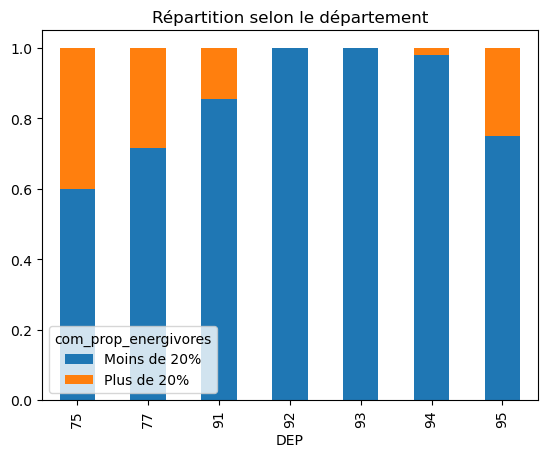

In [86]:
pd.crosstab(Filosofi_dpe_IDF_com2["DEP"],Filosofi_dpe_IDF_com2["com_prop_energivores"],\
            normalize='index').plot.bar(stacked=True,title="Répartition selon le département")

On peut remarquer que c'est à Paris que l'on trouve la plus forte proportion de communes (en l'occurrence il s'agit ici des 20 arrondissements) affichant plus de 20% de logements diagostiqués énergivores. On peut imaginer que la dimension historique d'une partie importante des logements parisiens (immeubles haussmaniens) peut contribuer à ce résultat. A contrario, les départements du 92 ou du 93 ne présentent pas de communes avec plus de 20% de logements diagnostiqués F ou G.

<AxesSubplot: title={'center': 'Répartition selon la taille des communes'}, xlabel='classe_taille_com'>

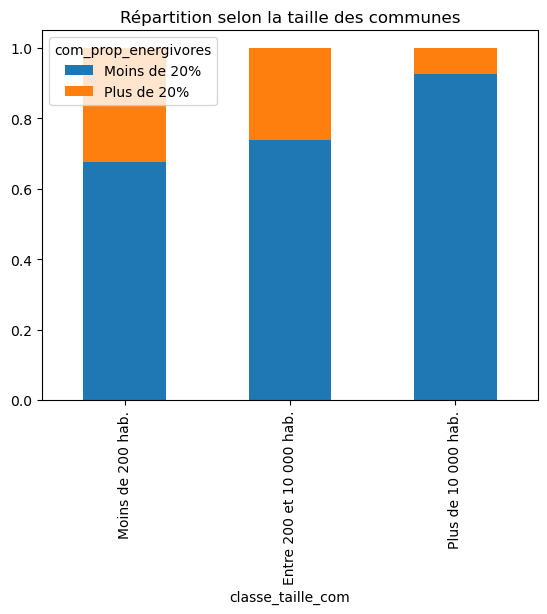

In [89]:
pd.crosstab(Filosofi_dpe_IDF_com2["classe_taille_com"],Filosofi_dpe_IDF_com2["com_prop_energivores"],\
            normalize='index').plot.bar(stacked=True,title="Répartition selon la taille des communes")

En moyenne, il apparaît que plus la commune est de grande taille, plus la part de communes avec plus de 20% de logements énergivores est faible. Il semble que les catégories F et G concernent davantage des petites communes, souvent en milieu plus rural.

<AxesSubplot: title={'center': 'Répartition selon le niveau de vie des communes'}, xlabel='MED16_quintiles'>

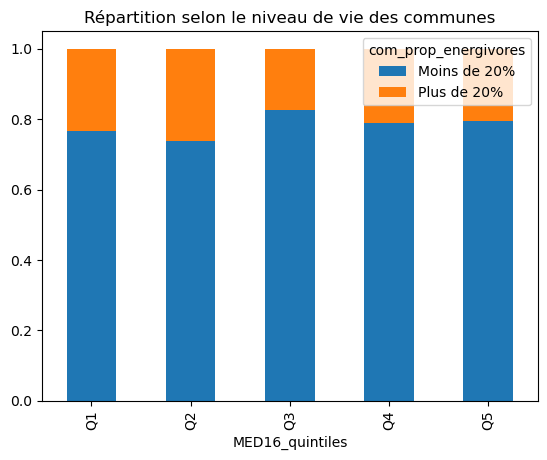

In [90]:
pd.crosstab(Filosofi_dpe_IDF_com2["MED16_quintiles"],Filosofi_dpe_IDF_com2["com_prop_energivores"],\
            normalize='index').plot.bar(stacked=True,title="Répartition selon le niveau de vie des communes")

A première vue, il ne semble pas qu'il y ait un lien très net entre le niveau de vie de la commune et la forte proportion de logements énergivores dans cette commune. Certes, on peut voir que dans les communes les plus défavorisés (Q1 et Q2 du niveau de vie) la proportion de communes présentant plus de 20% de logements énergivores est légèrement plus élevée que dans les quintiles de niveau de vie supérieurs, mais la différence reste assez légère.

#### 3) Quelles corrélations statistiques entre les différentes variables quantitatives?

##### a) Matrice de corrélation des principales variables quantitatives disponibles au niveau communal

In [ ]:
Nous 

<AxesSubplot: >

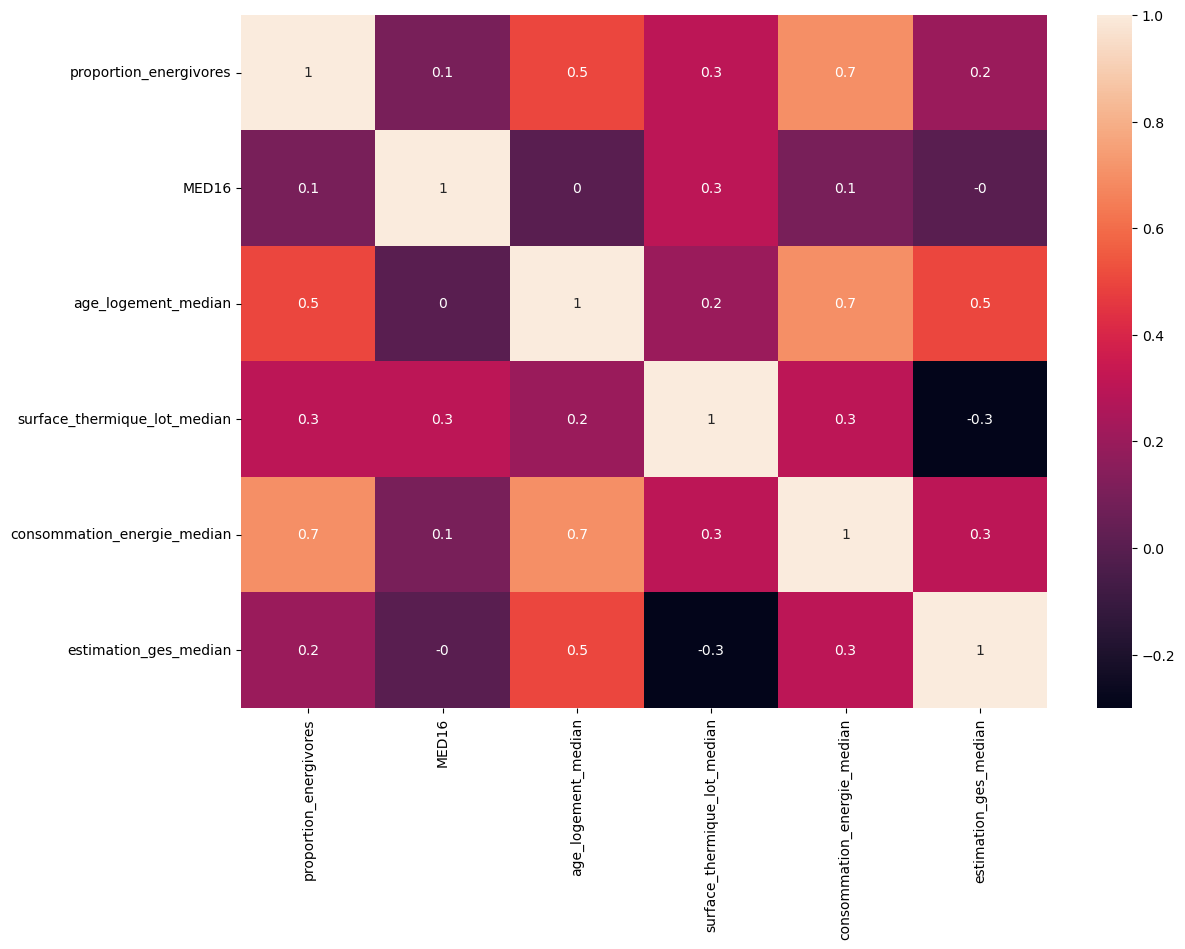

In [41]:
matrice_corr = Filosofi_dpe_IDF_com2[["proportion_energivores", "MED16" , "age_logement_median","surface_thermique_lot_median", "consommation_energie_median", "estimation_ges_median"]].corr(method='spearman').round(1)
f, ax = plt.subplots(figsize=(13, 9))
sns.heatmap(data=matrice_corr, annot=True, center=None)

In [ ]:
plt.figure()
plt.subplot(4,2,1)
Filosofi_DPE_75=Filosofi_dpe_IDF_com2[Filosofi_dpe_IDF_com2["DEP"]==75]
plt.scatter(Filosofi_DPE_75["MED16"],Filosofi_DPE_75["proportion_energivores_pct"])
plt.title("75")
plt.subplot(4,2,2)
Filosofi_DPE_77=Filosofi_dpe_IDF_com2[Filosofi_dpe_IDF_com2["DEP"]==77]
plt.scatter(Filosofi_DPE_77["MED16"],Filosofi_DPE_77["proportion_energivores_pct"])
plt.title("77")
plt.subplot(4,2,3)
Filosofi_DPE_91=Filosofi_dpe_IDF_com2[Filosofi_dpe_IDF_com2["DEP"]==91]
plt.scatter(Filosofi_DPE_91["MED16"],Filosofi_DPE_91["proportion_energivores_pct"])
plt.title("91")
plt.subplot(4,2,4)
Filosofi_DPE_92=Filosofi_dpe_IDF_com2[Filosofi_dpe_IDF_com2["DEP"]==92]
plt.scatter(Filosofi_DPE_92["MED16"],Filosofi_DPE_92["proportion_energivores_pct"])
plt.title("92")
plt.subplot(4,2,5)
Filosofi_DPE_93=Filosofi_dpe_IDF_com2[Filosofi_dpe_IDF_com2["DEP"]==93]
plt.scatter(Filosofi_DPE_93["MED16"],Filosofi_DPE_93["proportion_energivores_pct"])
plt.title("93")
plt.subplot(4,2,6)
Filosofi_DPE_94=Filosofi_dpe_IDF_com2[Filosofi_dpe_IDF_com2["DEP"]==94]
plt.scatter(Filosofi_DPE_94["MED16"],Filosofi_DPE_94["proportion_energivores_pct"])
plt.title("94")
plt.subplot(4,2,7)
Filosofi_DPE_95=Filosofi_dpe_IDF_com2[Filosofi_dpe_IDF_com2["DEP"]==95]
plt.scatter(Filosofi_DPE_95["MED16"],Filosofi_DPE_95["proportion_energivores_pct"])
plt.title("95")

Text(0.5, 1.0, "Poids des logements énergivores dans les communes d'Ile-de-France en fonction de leur niveau de vie médian")

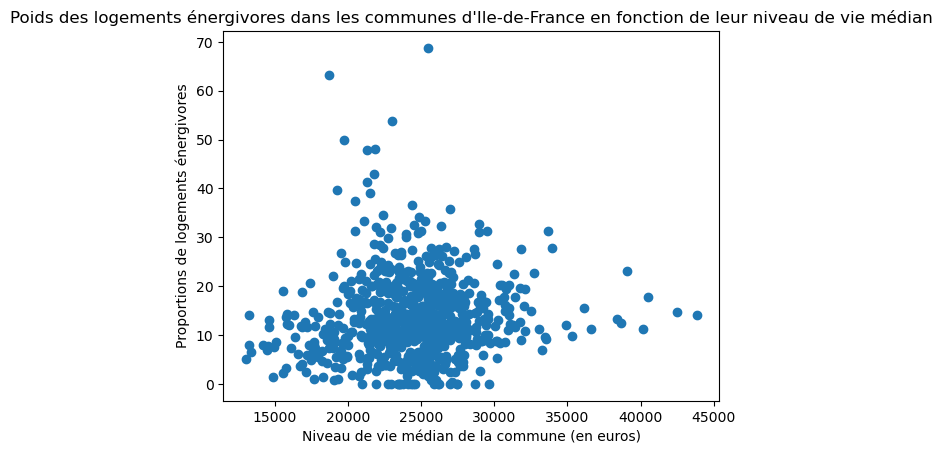

In [39]:
# Nuage de points: niveau de vie médian de la commune vs proportion de logements énergivores (classes F ou G)
plt.figure()
plt.scatter(Filosofi_dpe_IDF_com2["MED16"],Filosofi_dpe_IDF_com2["proportion_energivores_pct"])
plt.xlabel("Niveau de vie médian de la commune (en euros)")
plt.ylabel("Proportions de logements énergivores")
plt.title("Poids des logements énergivores dans les communes d'Ile-de-France en fonction de leur niveau de vie médian")

In [46]:
Filosofi_dpe_IDF_com2["DEP"]

0      75
1      75
2      75
3      75
4      75
       ..
746    95
747    95
748    95
749    95
750    95
Name: DEP, Length: 751, dtype: int64

In [47]:
#plt.figure()
Filosofi_DPE_75=Filosofi_dpe_IDF_com2.loc[Filosofi_dpe_IDF_com2["DEP"]==75,:]
Filosofi_DPE_75
#plt.scatter(Filosofi_DPE_75["MED16"],Filosofi_DPE_75["proportion_energivores_pct"])

,index,CODGEO,LIBGEO,NBMENFISC16,NBPERSMENFISC16,MED16,DEP,MED16_quintiles,code_insee_commune_actualise,consommation_energie,...,estimation_ges_quintiles_Q4,estimation_ges_quintiles_Q5,surface_thermique_lot_median,age_logement_median,consommation_energie_median,estimation_ges_median,nombre_dpe,ratio_DPE_menage,proportion_energivores,proportion_energivores_pct
0,1,75101,Paris 1er Arrondissement,8483.0,15477.0,32697.333333,75,Q5,75101.0,251.767217,...,0.238532,0.241590,47.705,68.0,229.220,19.455,1308.0,0.154191,0.227064,22.706422
1,3,75103,Paris 3e Arrondissement,17727.0,32292.5,31333.000000,75,Q5,75103.0,253.869358,...,0.207894,0.171179,45.510,67.0,233.120,13.750,2179.0,0.122920,0.223956,22.395594
2,4,75104,Paris 4e Arrondissement,13955.0,25585.5,31007.222222,75,Q5,75104.0,218.207240,...,0.187842,0.168716,49.035,67.0,207.360,12.680,1464.0,0.104909,0.202186,20.218579
3,6,75106,Paris 6e Arrondissement,18276.0,34144.5,39062.666667,75,Q5,75106.0,265.447392,...,0.244198,0.227548,45.875,67.0,237.620,20.465,1982.0,0.108448,0.231584,23.158426
4,7,75107,Paris 7e Arrondissement,24479.0,48151.5,42465.555556,75,Q5,75107.0,240.012553,...,0.298867,0.248938,57.200,67.0,216.185,25.525,2824.0,0.115364,0.147663,14.766289
5,8,75108,Paris 8e Arrondissement,17591.0,37836.0,40540.000000,75,Q5,75108.0,231.518467,...,0.287208,0.261822,71.150,67.0,204.480,26.320,2009.0,0.114206,0.178696,17.869587
6,14,75114,Paris 14e Arrondissement,63272.0,122565.5,27287.600000,75,Q4,75114.0,196.186053,...,0.149266,0.182278,34.880,40.0,186.630,13.460,6331.0,0.100060,0.129048,12.904754
7,16,75116,Paris 16e Arrondissement,73276.0,154590.0,38387.000000,75,Q5,75116.0,243.699356,...,0.262758,0.414524,65.710,53.0,212.210,38.560,7505.0,0.102421,0.132045,13.204530
8,19,75119,Paris 19e Arrondissement,79899.0,185576.0,19610.666667,75,Q1,75119.0,152.868785,...,0.318059,0.122900,44.000,14.0,98.880,19.090,8511.0,0.106522,0.083774,8.377394


In [62]:
Filosofi_DPE_75

,index,CODGEO,LIBGEO,NBMENFISC16,NBPERSMENFISC16,MED16,DEP,MED16_quintiles,code_insee_commune_actualise,consommation_energie,...,estimation_ges_quintiles_Q4,estimation_ges_quintiles_Q5,surface_thermique_lot_median,age_logement_median,consommation_energie_median,estimation_ges_median,nombre_dpe,ratio_DPE_menage,proportion_energivores,proportion_energivores_pct
0,1,75101,Paris 1er Arrondissement,8483.0,15477.0,32697.333333,75,Q5,75101.0,251.767217,...,0.238532,0.241590,47.705,68.0,229.220,19.455,1308.0,0.154191,0.227064,22.706422
1,3,75103,Paris 3e Arrondissement,17727.0,32292.5,31333.000000,75,Q5,75103.0,253.869358,...,0.207894,0.171179,45.510,67.0,233.120,13.750,2179.0,0.122920,0.223956,22.395594
2,4,75104,Paris 4e Arrondissement,13955.0,25585.5,31007.222222,75,Q5,75104.0,218.207240,...,0.187842,0.168716,49.035,67.0,207.360,12.680,1464.0,0.104909,0.202186,20.218579
3,6,75106,Paris 6e Arrondissement,18276.0,34144.5,39062.666667,75,Q5,75106.0,265.447392,...,0.244198,0.227548,45.875,67.0,237.620,20.465,1982.0,0.108448,0.231584,23.158426
4,7,75107,Paris 7e Arrondissement,24479.0,48151.5,42465.555556,75,Q5,75107.0,240.012553,...,0.298867,0.248938,57.200,67.0,216.185,25.525,2824.0,0.115364,0.147663,14.766289
5,8,75108,Paris 8e Arrondissement,17591.0,37836.0,40540.000000,75,Q5,75108.0,231.518467,...,0.287208,0.261822,71.150,67.0,204.480,26.320,2009.0,0.114206,0.178696,17.869587
6,14,75114,Paris 14e Arrondissement,63272.0,122565.5,27287.600000,75,Q4,75114.0,196.186053,...,0.149266,0.182278,34.880,40.0,186.630,13.460,6331.0,0.100060,0.129048,12.904754
7,16,75116,Paris 16e Arrondissement,73276.0,154590.0,38387.000000,75,Q5,75116.0,243.699356,...,0.262758,0.414524,65.710,53.0,212.210,38.560,7505.0,0.102421,0.132045,13.204530
8,19,75119,Paris 19e Arrondissement,79899.0,185576.0,19610.666667,75,Q1,75119.0,152.868785,...,0.318059,0.122900,44.000,14.0,98.880,19.090,8511.0,0.106522,0.083774,8.377394


Text(0.5, 1.0, '95')

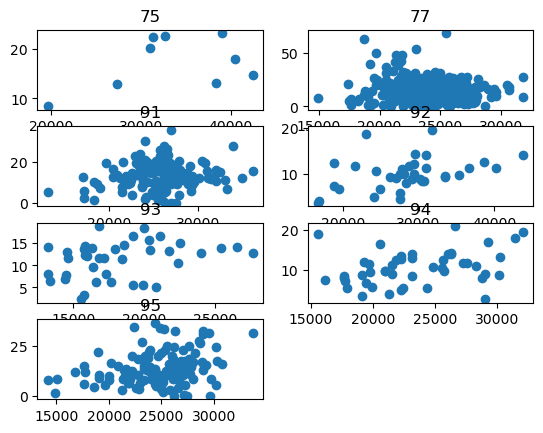

In [48]:
# Distinction selon les départements d'IDF (hors Paris):
plt.figure()
plt.subplot(4,2,1)
Filosofi_DPE_75=Filosofi_dpe_IDF_com2[Filosofi_dpe_IDF_com2["DEP"]==75]
plt.scatter(Filosofi_DPE_75["MED16"],Filosofi_DPE_75["proportion_energivores_pct"])
plt.title("75")
plt.subplot(4,2,2)
Filosofi_DPE_77=Filosofi_dpe_IDF_com2[Filosofi_dpe_IDF_com2["DEP"]==77]
plt.scatter(Filosofi_DPE_77["MED16"],Filosofi_DPE_77["proportion_energivores_pct"])
plt.title("77")
plt.subplot(4,2,3)
Filosofi_DPE_91=Filosofi_dpe_IDF_com2[Filosofi_dpe_IDF_com2["DEP"]==91]
plt.scatter(Filosofi_DPE_91["MED16"],Filosofi_DPE_91["proportion_energivores_pct"])
plt.title("91")
plt.subplot(4,2,4)
Filosofi_DPE_92=Filosofi_dpe_IDF_com2[Filosofi_dpe_IDF_com2["DEP"]==92]
plt.scatter(Filosofi_DPE_92["MED16"],Filosofi_DPE_92["proportion_energivores_pct"])
plt.title("92")
plt.subplot(4,2,5)
Filosofi_DPE_93=Filosofi_dpe_IDF_com2[Filosofi_dpe_IDF_com2["DEP"]==93]
plt.scatter(Filosofi_DPE_93["MED16"],Filosofi_DPE_93["proportion_energivores_pct"])
plt.title("93")
plt.subplot(4,2,6)
Filosofi_DPE_94=Filosofi_dpe_IDF_com2[Filosofi_dpe_IDF_com2["DEP"]==94]
plt.scatter(Filosofi_DPE_94["MED16"],Filosofi_DPE_94["proportion_energivores_pct"])
plt.title("94")
plt.subplot(4,2,7)
Filosofi_DPE_95=Filosofi_dpe_IDF_com2[Filosofi_dpe_IDF_com2["DEP"]==95]
plt.scatter(Filosofi_DPE_95["MED16"],Filosofi_DPE_95["proportion_energivores_pct"])
plt.title("95")

Text(0.5, 1.0, "Poids des logements énergivores dans les communes d'Ile-de-France en fonction de l'ancienneté des logements")

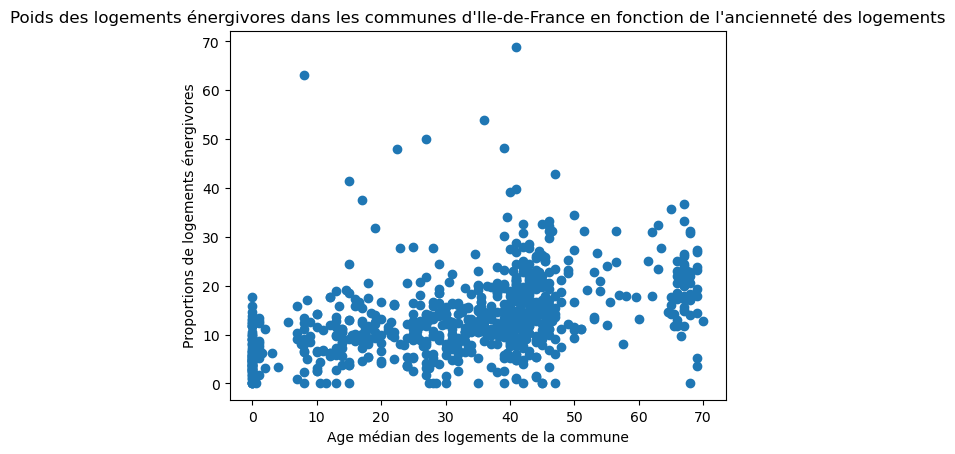

In [40]:
# Nuage de points: äge médian des logements de la commune vs proportion de logements énergivores (classes F ou G)
plt.figure()
plt.scatter(Filosofi_dpe_IDF_com2["age_logement_median"],Filosofi_dpe_IDF_com2["proportion_energivores_pct"])
plt.xlabel("Age médian des logements de la commune")
plt.ylabel("Proportions de logements énergivores")
plt.title("Poids des logements énergivores dans les communes d'Ile-de-France en fonction de l'ancienneté des logements")

##### b) Distribution de la proportion de logements énergivores au sein des communes d'Ile-de-France selon leur niveau de vie médian: 

Text(0.5, 0, 'Niveau de vie médian dans les communes')

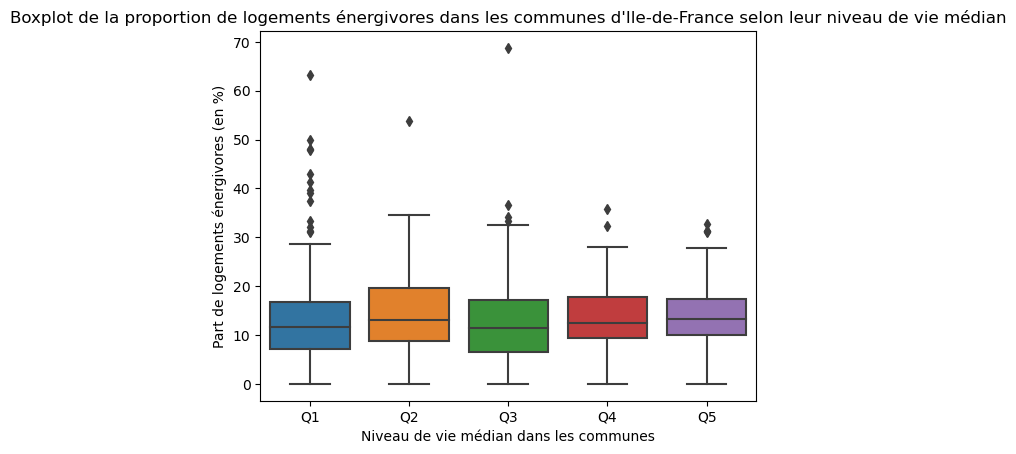

In [38]:
Filosofi_dpe_IDF_com2["proportion_energivores_pct"]=Filosofi_dpe_IDF_com2["proportion_energivores"].apply(lambda x: x*100)
sns.boxplot(data=Filosofi_dpe_IDF_com2,y="proportion_energivores_pct",x="MED16_quintiles",order=["Q1","Q2","Q3","Q4","Q5"])
plt.title("Boxplot de la proportion de logements énergivores dans les communes d'Ile-de-France selon leur niveau de vie médian")
plt.ylabel("Part de logements énergivores (en %)")
plt.xlabel("Niveau de vie médian dans les communes")

On ne voit pas de relation évidente entre la distribution de la proportion de logements énergivores au sein des communes d'Ile-de-France et leur niveau de vie médian. Vérifions que cela est bien le cas pour chaque département d'Ile-de-France:

Text(0.5, 0, 'Département')

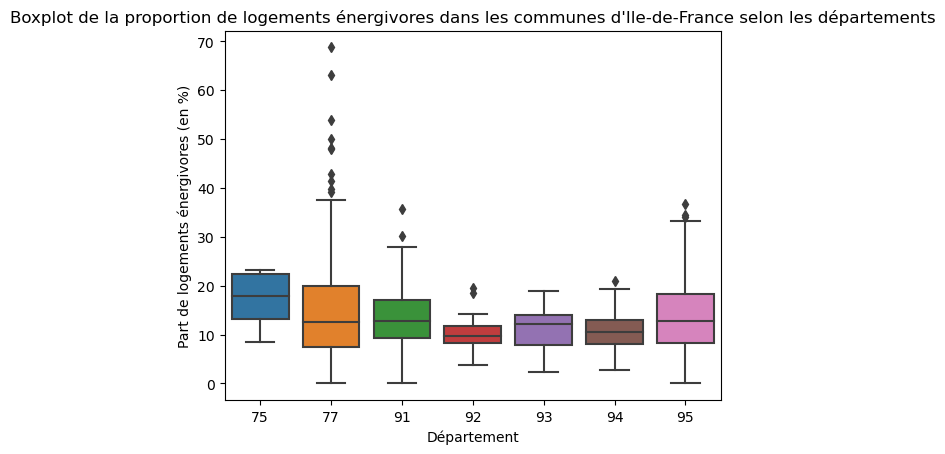

In [51]:
Filosofi_dpe_IDF_com2["proportion_energivores_pct"]=Filosofi_dpe_IDF_com2["proportion_energivores"].apply(lambda x: x*100)
sns.boxplot(data=Filosofi_dpe_IDF_com2,y="proportion_energivores_pct",x="DEP")
plt.title("Boxplot de la proportion de logements énergivores dans les communes d'Ile-de-France selon les départements")
plt.ylabel("Part de logements énergivores (en %)")
plt.xlabel("Département")

In [61]:
#on regarde quelles sont les communes très pauvre et très énergivores:
filtre=(Filosofi_dpe_IDF_com2["MED16_quintiles"]=="Q1")&(Filosofi_dpe_IDF_com2["proportion_energivores_pct"]>30)
commune_energivores_pauvres=Filosofi_dpe_IDF_com2[filtre]
commune_energivores_pauvres.sort_values(by="NBMENFISC16",ascending=False)

,index,CODGEO,LIBGEO,NBMENFISC16,NBPERSMENFISC16,MED16,DEP,MED16_quintiles,code_insee_commune_actualise,consommation_energie,...,estimation_ges_quintiles_Q4,estimation_ges_quintiles_Q5,surface_thermique_lot_median,age_logement_median,consommation_energie_median,estimation_ges_median,nombre_dpe,ratio_DPE_menage,proportion_energivores,proportion_energivores_pct
216,304,77296,Moissy-Cramayel,6155.0,17664.0,20508.000000,77,Q1,77296.0,235.832352,...,0.138970,0.270165,60.000,17.0,225.740,16.500,1029.0,0.167181,0.375121,37.512148
159,223,77215,Gretz-Armainvilliers,3276.0,8524.0,21867.878788,77,Q1,77215.0,306.144676,...,0.103118,0.515588,71.000,39.0,319.830,49.340,834.0,0.254579,0.480815,48.081535
47,69,77051,Bray-sur-Seine,974.0,2089.0,19222.666667,77,Q1,77051.0,310.455000,...,0.053922,0.745098,64.000,41.0,304.000,71.100,204.0,0.209446,0.397059,39.705882
189,268,77260,Longueville,693.0,1754.0,18686.428571,77,Q1,77260.0,385.449811,...,0.660377,0.169811,66.430,8.0,469.400,27.900,106.0,0.152958,0.632075,63.207547
348,512,77519,Villiers-Saint-Georges,438.0,1171.5,19696.666667,77,Q1,77519.0,316.897833,...,0.466667,0.150000,84.000,27.0,330.120,28.600,60.0,0.136986,0.500000,50.000000
96,131,77117,Citry,337.0,920.5,20508.333333,77,Q1,77117.0,277.784191,...,0.172794,0.297794,99.610,68.0,273.185,19.000,272.0,0.807122,0.312500,31.250000
206,291,77283,May-en-Multien,313.0,913.0,21935.333333,77,Q1,77283.0,260.695932,...,0.135593,0.135593,97.500,46.0,255.000,11.000,59.0,0.188498,0.322034,32.203390
212,299,77291,Le Mesnil-Amelot,294.0,849.0,21310.000000,77,Q1,77291.0,230.326533,...,0.106667,0.093333,71.420,15.0,271.760,19.300,75.0,0.255102,0.413333,41.333333
65,92,77076,Chalmaison,276.0,768.0,22197.000000,77,Q1,77076.0,291.087807,...,0.219298,0.219298,96.095,46.0,261.930,17.905,228.0,0.826087,0.311404,31.140351
342,504,77511,Villeneuve-sous-Dammartin,237.0,620.5,21331.724138,77,Q1,77511.0,304.776042,...,0.270833,0.020833,60.000,22.5,328.495,18.620,48.0,0.202532,0.479167,47.916667


In [60]:
#on regarde quelles sont les communes très énergivores ds le 77:
filtre=(Filosofi_dpe_IDF_com2["DEP"]==77)&(Filosofi_dpe_IDF_com2["proportion_energivores_pct"]>38)
commune_energivores_77=Filosofi_dpe_IDF_com2[filtre]
commune_energivores_77.sort_values(by="NBMENFISC16",ascending=False)

,index,CODGEO,LIBGEO,NBMENFISC16,NBPERSMENFISC16,MED16,DEP,MED16_quintiles,code_insee_commune_actualise,consommation_energie,...,estimation_ges_quintiles_Q4,estimation_ges_quintiles_Q5,surface_thermique_lot_median,age_logement_median,consommation_energie_median,estimation_ges_median,nombre_dpe,ratio_DPE_menage,proportion_energivores,proportion_energivores_pct
159,223,77215,Gretz-Armainvilliers,3276.0,8524.0,21867.878788,77,Q1,77215.0,306.144676,...,0.103118,0.515588,71.00,39.0,319.830,49.34,834.0,0.254579,0.480815,48.081535
47,69,77051,Bray-sur-Seine,974.0,2089.0,19222.666667,77,Q1,77051.0,310.455000,...,0.053922,0.745098,64.00,41.0,304.000,71.10,204.0,0.209446,0.397059,39.705882
189,268,77260,Longueville,693.0,1754.0,18686.428571,77,Q1,77260.0,385.449811,...,0.660377,0.169811,66.43,8.0,469.400,27.90,106.0,0.152958,0.632075,63.207547
348,512,77519,Villiers-Saint-Georges,438.0,1171.5,19696.666667,77,Q1,77519.0,316.897833,...,0.466667,0.150000,84.00,27.0,330.120,28.60,60.0,0.136986,0.500000,50.000000
212,299,77291,Le Mesnil-Amelot,294.0,849.0,21310.000000,77,Q1,77291.0,230.326533,...,0.106667,0.093333,71.42,15.0,271.760,19.30,75.0,0.255102,0.413333,41.333333
170,245,77237,Jossigny,239.0,652.0,25461.055556,77,Q3,77237.0,378.806250,...,0.593750,0.093750,63.25,41.0,454.800,26.70,32.0,0.133891,0.687500,68.750000
342,504,77511,Villeneuve-sous-Dammartin,237.0,620.5,21331.724138,77,Q1,77511.0,304.776042,...,0.270833,0.020833,60.00,22.5,328.495,18.62,48.0,0.202532,0.479167,47.916667
175,250,77242,Jutigny,223.0,554.5,21541.333333,77,Q1,77242.0,299.876957,...,0.304348,0.304348,82.00,40.0,298.000,33.00,23.0,0.103139,0.391304,39.130435
298,433,77434,Saint-Sauveur-lès-Bray,162.0,360.5,22985.238095,77,Q2,77434.0,358.836538,...,0.346154,0.153846,66.50,36.0,367.105,21.08,26.0,0.160494,0.538462,53.846154
229,326,77319,Mortery,61.0,159.5,21772.000000,77,Q1,77319.0,279.081429,...,0.142857,0.285714,96.00,47.0,283.010,20.00,7.0,0.114754,0.428571,42.857143


Text(0.5, 0, 'Département')

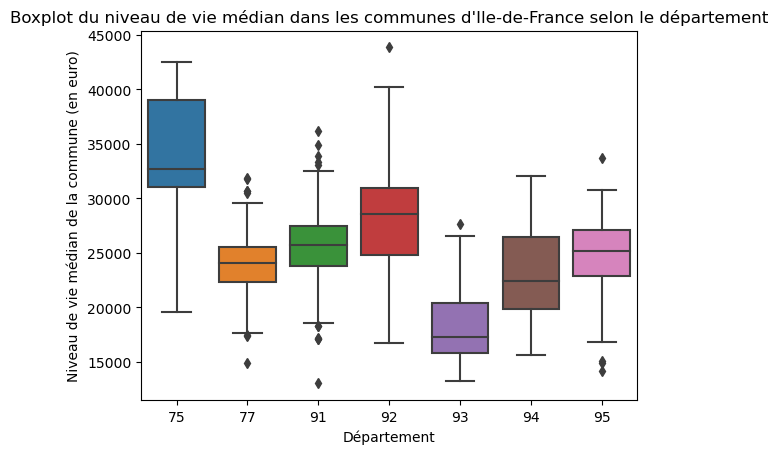

In [50]:
sns.boxplot(data=Filosofi_dpe_IDF_com2,y="MED16",x="DEP")
plt.title("Boxplot du niveau de vie médian dans les communes d'Ile-de-France selon le département")
plt.ylabel("Niveau de vie médian de la commune (en euro)")
plt.xlabel("Département")

## **II) Modélisation: prédiction de la structure des logements d'une commune en classes de consommation énergétique**

In [10]:
# Modèle logistique multinomial?
# Variable à expliquer: la structure des logements de la commune en termes de consommation énergétique
# Variables explicatives: le type de logement, la surface moyenne, l'ancienneté du logement, 
# le niveau de vie médian de la commune, milieur rural/milieu urbain, etc.



In [11]:
# On commence par faire une ACP

# Etape 0 : choix des variables
Filosofi_dpe_IDF_com1=Filosofi_dpe_IDF_com.dropna()
variable=['nombre_dpe','surface_thermique_lot_median','age_logement_median','NBPERSMENFISC16','classe_age_Neuf (<5ans)'
         ,'classe_age_Entre 50 et 100 ans','classe_age_Récent (entre 5 et 10 ans)','classe_age_Entre 10 et 25 ans',
          "classe_age_Entre 25 et 50 ans","classe_age_Plus de 100 ans","MED16","surface_thermique_lot_median"]

use_dpe=Filosofi_dpe_IDF_com1[variable]
use_dpe.head()

,nombre_dpe,surface_thermique_lot_median,age_logement_median,NBPERSMENFISC16,classe_age_Neuf (<5ans),classe_age_Entre 50 et 100 ans,classe_age_Récent (entre 5 et 10 ans),classe_age_Entre 10 et 25 ans,classe_age_Entre 25 et 50 ans,classe_age_Plus de 100 ans,MED16,surface_thermique_lot_median
0,7765.0,43.815,66.0,2074629.5,0.026272,0.709208,0.006825,0.033612,0.088088,0.135995,26808.000000,43.815
1,1308.0,47.705,68.0,15477.0,0.032875,0.583333,0.000765,0.019878,0.280581,0.082569,32697.333333,47.705
2,1124.0,41.215,65.0,20563.0,0.001779,0.451068,0.002669,0.008897,0.459964,0.075623,30566.500000,41.215
3,2179.0,45.510,67.0,32292.5,0.004589,0.510326,0.002295,0.026159,0.396971,0.059660,31333.000000,45.510
4,1464.0,49.035,67.0,25585.5,0.096995,0.476776,0.001366,0.002732,0.312842,0.109290,31007.222222,49.035


In [12]:
# Standardisation 
scaler = StandardScaler()
scaler.fit(use_dpe)

StandardScaler()

In [13]:
use_dpe.head()

,nombre_dpe,surface_thermique_lot_median,age_logement_median,NBPERSMENFISC16,classe_age_Neuf (<5ans),classe_age_Entre 50 et 100 ans,classe_age_Récent (entre 5 et 10 ans),classe_age_Entre 10 et 25 ans,classe_age_Entre 25 et 50 ans,classe_age_Plus de 100 ans,MED16,surface_thermique_lot_median
0,7765.0,43.815,66.0,2074629.5,0.026272,0.709208,0.006825,0.033612,0.088088,0.135995,26808.000000,43.815
1,1308.0,47.705,68.0,15477.0,0.032875,0.583333,0.000765,0.019878,0.280581,0.082569,32697.333333,47.705
2,1124.0,41.215,65.0,20563.0,0.001779,0.451068,0.002669,0.008897,0.459964,0.075623,30566.500000,41.215
3,2179.0,45.510,67.0,32292.5,0.004589,0.510326,0.002295,0.026159,0.396971,0.059660,31333.000000,45.510
4,1464.0,49.035,67.0,25585.5,0.096995,0.476776,0.001366,0.002732,0.312842,0.109290,31007.222222,49.035


In [14]:
sc_dpe =pd.DataFrame(data=scaler.transform(use_dpe),index=Filosofi_dpe_IDF_com1["CODGEO"],columns=variable)

Text(0, 0.5, 'Variance cumulative expliquée')

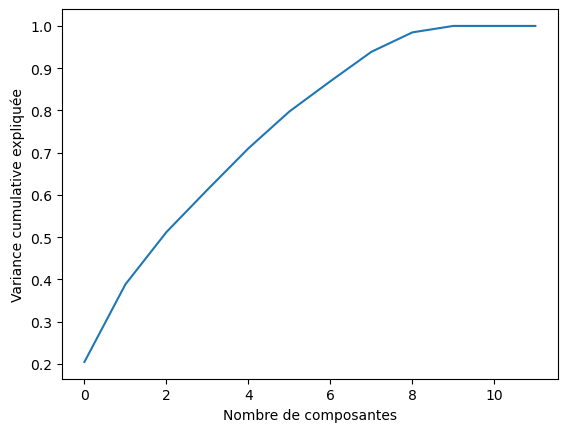

In [15]:
# Choix du nombre de composantes

pca = PCA().fit(sc_dpe)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Nombre de composantes')
plt.ylabel('Variance cumulative expliquée')

### On choisit d'implémenter avec 5 composantes

In [16]:
pca=PCA(n_components=5)

In [17]:
pca.fit(sc_dpe)

PCA(n_components=5)

In [18]:
x_pca=pca.transform(sc_dpe)

In [19]:
x_pca.shape

(1013, 5)

In [20]:
# On choisir la couleur comme la proportion des logement énervore E,F et G
energivore=Filosofi_dpe_IDF_com1["classe_consommation_energie_G"]+Filosofi_dpe_IDF_com1["classe_consommation_energie_F"]+Filosofi_dpe_IDF_com1["classe_consommation_energie_E"]

In [21]:
result=pd.DataFrame(x_pca,columns=['PCA%i' % i for i in range(5)],index=use_dpe.index)
result["energivore"]=energivore
result["consommation_energie_median"]=Filosofi_dpe_IDF_com1["consommation_energie_median"]
result.head()

,PCA0,PCA1,PCA2,PCA3,PCA4,energivore,consommation_energie_median
0,6.157288,-9.685762,12.930031,-1.557052,15.902193,0.577205,253.000
1,2.964931,-0.951794,0.515148,1.159110,-1.174694,0.493884,229.220
2,2.762346,-0.901952,-0.240209,0.041442,-1.031468,0.491103,229.505
3,2.901943,-1.139304,0.176697,0.362437,-0.589157,0.502524,233.120
4,2.583523,-0.962149,0.677957,0.644645,-1.233377,0.437842,207.360


In [22]:
for i in list(result.columns):
    result=result[(result[i]!= max(result[i]))]   
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1002 entries, 1 to 1287
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   PCA0                         1002 non-null   float64
 1   PCA1                         1002 non-null   float64
 2   PCA2                         1002 non-null   float64
 3   PCA3                         1002 non-null   float64
 4   PCA4                         1002 non-null   float64
 5   energivore                   1002 non-null   float64
 6   consommation_energie_median  1002 non-null   float64
dtypes: float64(7)
memory usage: 62.6 KB


In [23]:
#Plot initialisation
#fig = plt.figure(figsize=(10,10))
#ax = fig.add_subplot(111, projection='3d')
#ax.scatter(result['PCA0'], result['PCA1'], result['PCA2'], c=result["energivore"], cmap="Set2_r", s=30)

# make simple, bare axis lines through space:
#xAxisLine = ((min(result['PCA0']), max(result['PCA0'])), (0, 0), (0,0))
#ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
#yAxisLine = ((0, 0), (min(result['PCA1']), max(result['PCA1'])), (0,0))
#ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
#zAxisLine = ((0, 0), (0,0), (min(result['PCA2']), max(result['PCA2'])))
#ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')

# label the axes
#ax.set_xlabel("PC1")
#ax.set_ylabel("PC2")
#ax.set_zlabel("PC3")
#ax.set_title("PCA")
#plt.show()'''

In [24]:
# Provoir explicatif du model
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())

[0.20479555 0.18371703 0.12356039 0.10025104 0.09791528]
0.7102392971239245


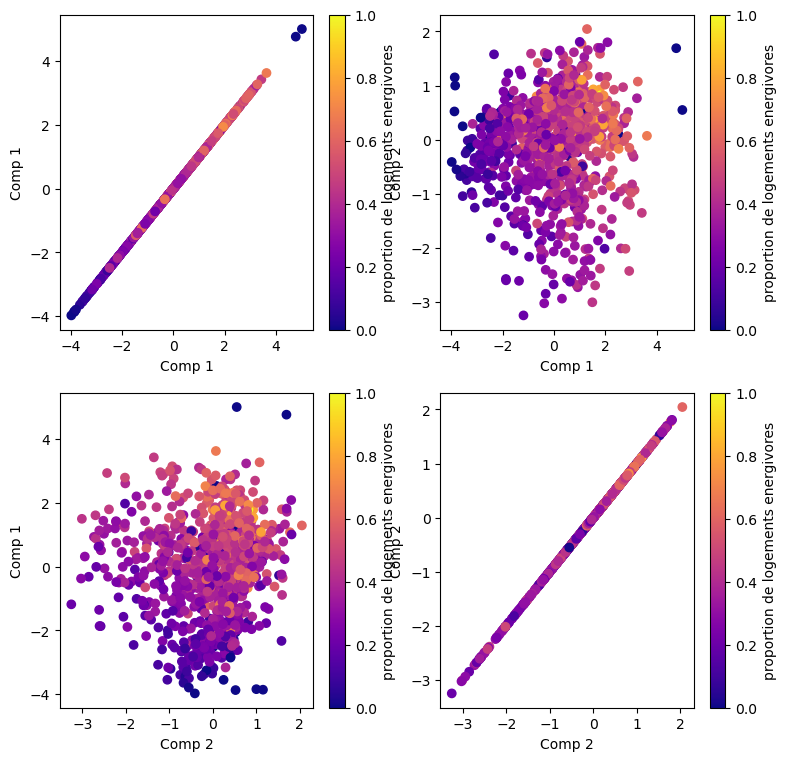

In [25]:
# Observation des ressembles sur les axes factorielles en fonction de la proportion
# de logements energivores

fig=plt.figure(figsize=(9,9))
plt.subplot(2,2,1)
plt.scatter(result["PCA0"],result["PCA0"], c=result['energivore'] , cmap = 'plasma')
plt.xlabel('Comp 1')
plt.ylabel('Comp 1')
plt.colorbar(label="proportion de logements energivores")

plt.subplot(2,2,2)
plt.scatter(result["PCA0"],result["PCA1"], c=result['energivore'] , cmap = 'plasma')
plt.xlabel('Comp 1')
plt.ylabel('Comp 2')
plt.colorbar(label="proportion de logements energivores")

plt.subplot(2,2,3)
plt.scatter(result["PCA1"],result["PCA0"], c=result['energivore'] , cmap = 'plasma')
plt.xlabel('Comp 2')
plt.ylabel('Comp 1')
plt.colorbar(label="proportion de logements energivores")

plt.subplot(2,2,4)
plt.scatter(result["PCA1"],result["PCA1"], c=result['energivore'] , cmap = 'plasma')
plt.xlabel('Comp 2')
plt.ylabel('Comp 2')
plt.colorbar(label="proportion de logements energivores")

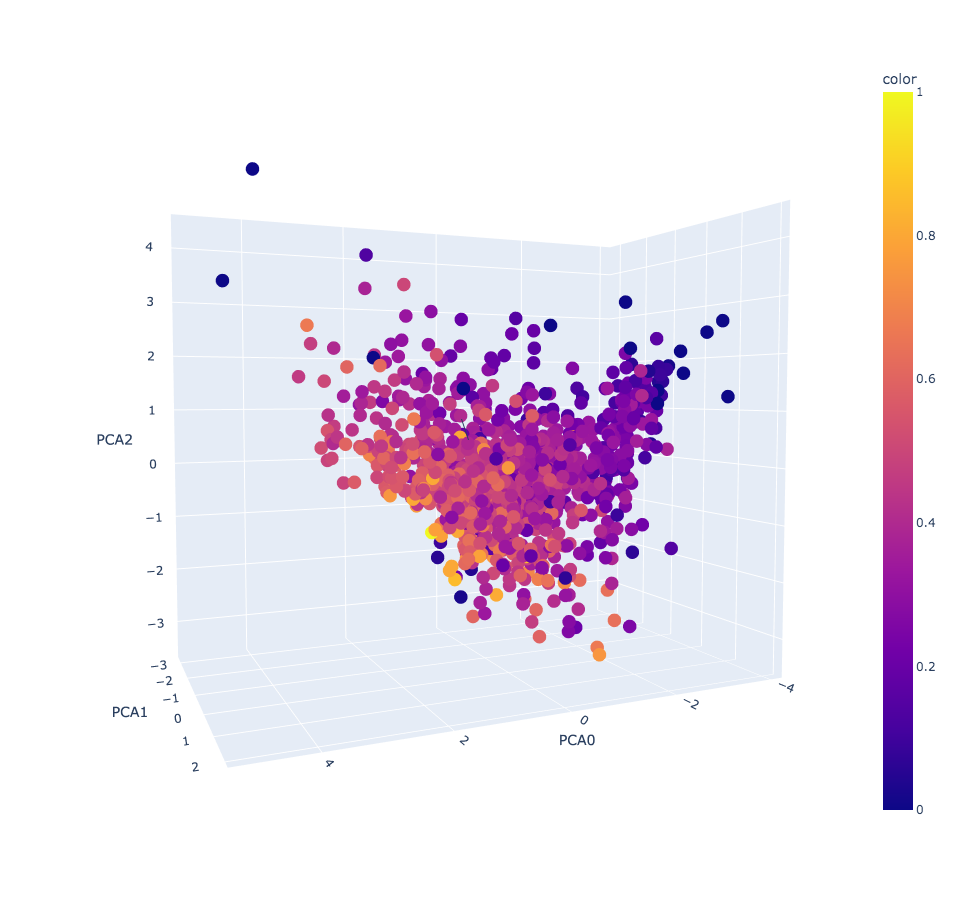

In [26]:
# Représentation dynamique en 3D  des axes factorielles en fonction de la proportion
# de logements energivores
#components = pca.fit_transform(sc_dpe)
var = pca.explained_variance_ratio_.sum() # variance expliquée
# Plot de la figure
fig = px.scatter_3d(data_frame=result[['PCA0','PCA1','PCA2']], x = 'PCA0', y='PCA1', z='PCA2',
                   color=result['energivore'],width=900,height=900)
fig.add_annotation()
fig.show()

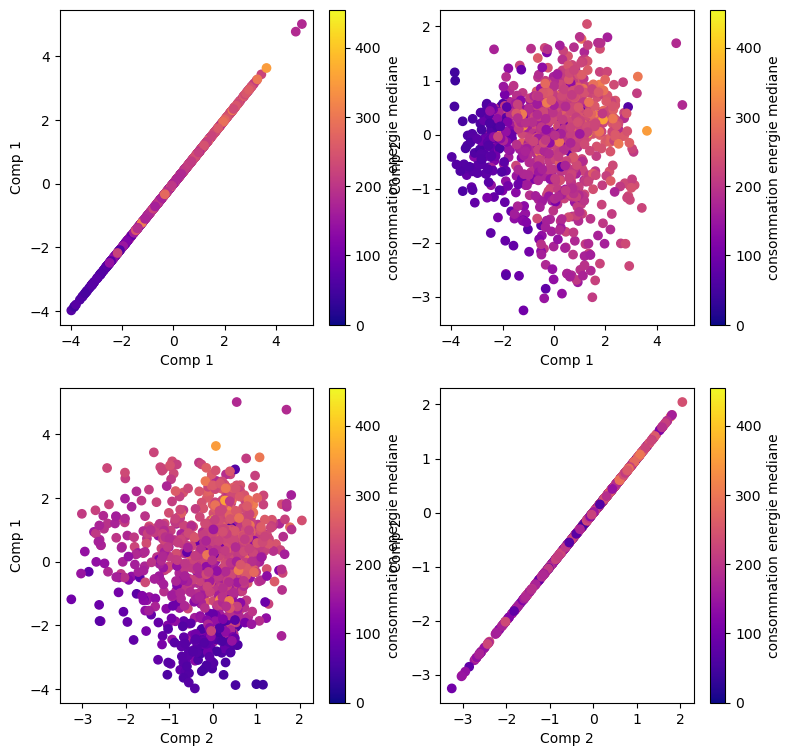

In [27]:

# Représentation dynamique en 3D  des axes factorielles en fonction de la consommation d'energie mediane dans
# led differentes communes

fig=plt.figure(figsize=(9,9))
plt.subplot(2,2,1)
plt.scatter(result["PCA0"],result["PCA0"], c=result['consommation_energie_median'] , cmap = 'plasma')
plt.xlabel('Comp 1')
plt.ylabel('Comp 1')
plt.colorbar(label="consommation energie mediane")

plt.subplot(2,2,2)
plt.scatter(result["PCA0"],result["PCA1"], c=result['consommation_energie_median'] , cmap = 'plasma')
plt.xlabel('Comp 1')
plt.ylabel('Comp 2')
plt.colorbar(label="consommation energie mediane")

plt.subplot(2,2,3)
plt.scatter(result["PCA1"],result["PCA0"], c=result['consommation_energie_median'] , cmap = 'plasma')
plt.xlabel('Comp 2')
plt.ylabel('Comp 1')
plt.colorbar(label="consommation energie mediane")

plt.subplot(2,2,4)
plt.scatter(result["PCA1"],result["PCA1"], c=result['consommation_energie_median'] , cmap = 'plasma')
plt.xlabel('Comp 2')
plt.ylabel('Comp 2')
plt.colorbar(label="consommation energie mediane")

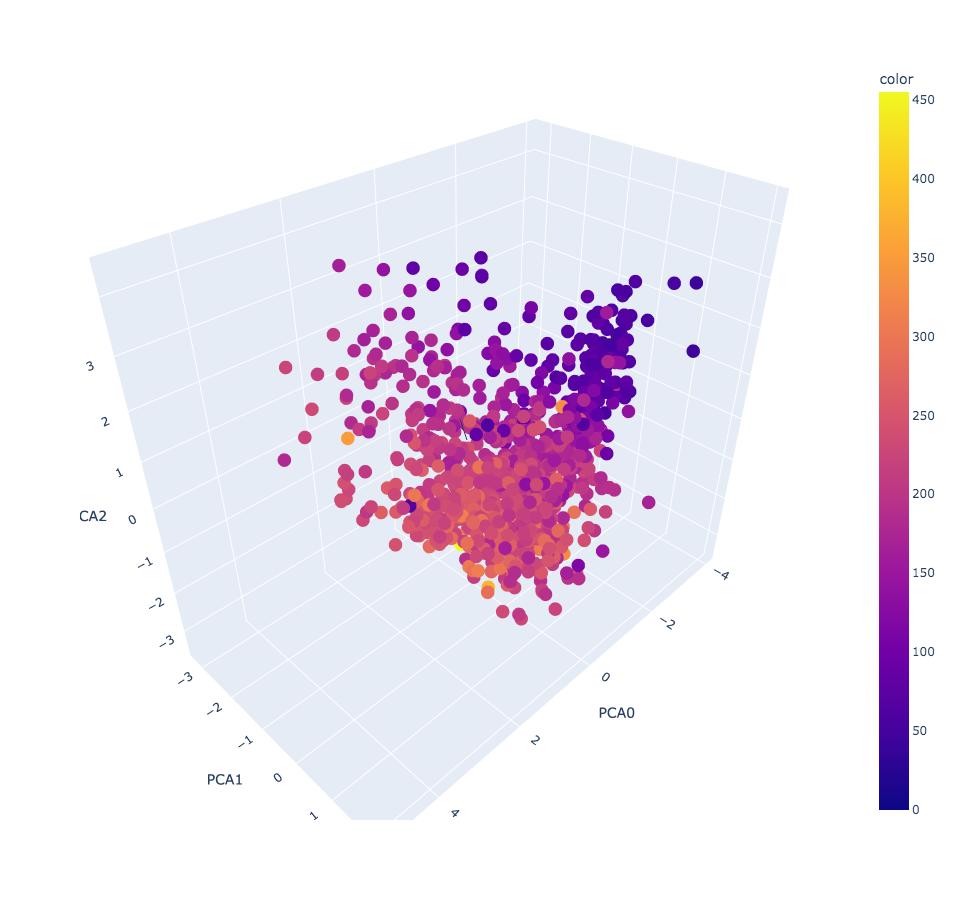

In [28]:
# Représentation dynamique en 3D  des axes factorielles en fonction de le consommation d'energie median
var = pca.explained_variance_ratio_.sum() # variance expliquée
# Plot de la figure
fig = px.scatter_3d(data_frame=result[['PCA0','PCA1','PCA2']], x = 'PCA0', y='PCA1', z='PCA2',
                   color=result['consommation_energie_median'],width=900,height=900)
fig.add_annotation()
fig.show()

### Implémentation de la regression Lasso

In [29]:
# Variables potientielles
variable=['nombre_dpe','surface_thermique_lot_median','age_logement_median','NBPERSMENFISC16','classe_age_Neuf (<5ans)'
         ,'classe_age_Entre 50 et 100 ans','classe_age_Récent (entre 5 et 10 ans)','classe_age_Entre 10 et 25 ans',
          "classe_age_Entre 25 et 50 ans","MED16","surface_thermique_lot_median",
          "classe_surface_Moins de 30 m2","classe_surface_Entre 30 et 60 m2","classe_surface_Entre 60 et 100 m2",'classe_surface_Plus de 100 m2']

In [30]:
data=Filosofi_dpe_IDF_com1[variable]
y=Filosofi_dpe_IDF_com1['classe_consommation_energie_E']+Filosofi_dpe_IDF_com1['classe_consommation_energie_F']+Filosofi_dpe_IDF_com1['classe_consommation_energie_G']

In [31]:
# Echantillon d'apprentissage et echantillon de test 70% et 30% respectivement
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.3, random_state=10)

In [32]:
# Standartissation des variables pour éviter les effets de taille et d'échèlle
scaler = StandardScaler().fit(X_train[variable])
X_train[variable] = scaler.transform(X_train[variable])
X_test[variable] = scaler.transform(X_test[variable])

## choix du alpha optimal

In [33]:
# Lasso with 20 fold cross-validation
model = LassoCV(cv=20, random_state=0, max_iter=10000)

In [34]:
# Fit model
model.fit(X_train, y_train)

LassoCV(cv=20, max_iter=10000, random_state=0)

In [35]:
LassoCV(cv=20, max_iter=10000, random_state=0)

LassoCV(cv=20, max_iter=10000, random_state=0)

In [36]:
model.alpha_

0.003886429547813475

In [37]:
# Set best alpha
lasso_best = Lasso(alpha=model.alpha_)
lasso_best.fit(X_train, y_train)

Lasso(alpha=0.003886429547813475)

In [38]:
Lasso(alpha=model.alpha_)

Lasso(alpha=0.003886429547813475)

In [39]:
#Show model coefficients and names:

print(list(zip(lasso_best.coef_, data)))

[(-0.029879940260094363, 'nombre_dpe'), (-0.002533966910000469, 'surface_thermique_lot_median'), (-0.0013856029513043314, 'age_logement_median'), (0.0010874825879789501, 'NBPERSMENFISC16'), (-0.06943278416929274, 'classe_age_Neuf (<5ans)'), (0.03384741900541682, 'classe_age_Entre 50 et 100 ans'), (-0.0, 'classe_age_Récent (entre 5 et 10 ans)'), (0.0014418776475795887, 'classe_age_Entre 10 et 25 ans'), (0.026435560569143996, 'classe_age_Entre 25 et 50 ans'), (0.0, 'MED16'), (-0.0009174374350973801, 'surface_thermique_lot_median'), (0.003644327330470134, 'classe_surface_Moins de 30 m2'), (0.0, 'classe_surface_Entre 30 et 60 m2'), (0.0, 'classe_surface_Entre 60 et 100 m2'), (-0.0, 'classe_surface_Plus de 100 m2')]


In [40]:
print('R squared training set', round(lasso_best.score(X_train, y_train)*100, 2))
print('R squared test set', round(lasso_best.score(X_test, y_test)*100, 2))

R squared training set 46.64
R squared test set 56.19


In [41]:
mean_squared_error(y_test, lasso_best.predict(X_test))

0.01217499022908874

(7.307910561759445e-05,
 0.1458119854504169,
 0.0036247952212548613,
 0.05611515428782952)

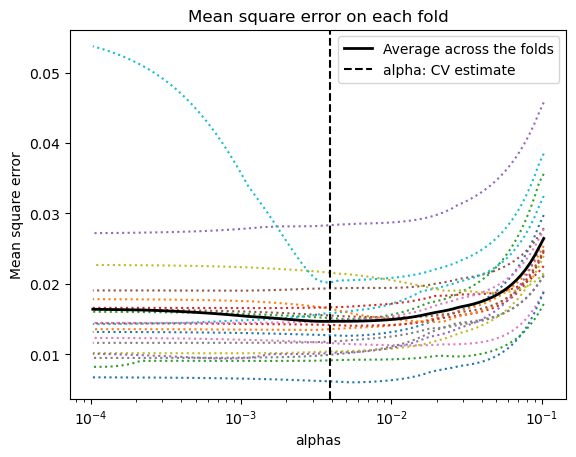

In [42]:
plt.semilogx(model.alphas_, model.mse_path_, ":")
plt.plot(
    model.alphas_ ,
    model.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight")

In [ ]:
## On reprend le meme model mais en u

In [43]:
data=Filosofi_dpe_IDF_com1[variable]
y=Filosofi_dpe_IDF_com1['consommation_energie_median']

In [44]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.3, random_state=10)

In [45]:
scaler = StandardScaler().fit(X_train[variable])
X_train[variable] = scaler.transform(X_train[variable])
X_test[variable] = scaler.transform(X_test[variable])

In [46]:
# Lasso with 5 fold cross-validation
model = LassoCV(cv=20, random_state=0, max_iter=10000)

In [47]:
# Fit model
model.fit(X_train, y_train)

LassoCV(cv=20, max_iter=10000, random_state=0)

In [48]:
LassoCV(cv=20, max_iter=10000, random_state=0)

LassoCV(cv=20, max_iter=10000, random_state=0)

In [49]:
model.alpha_

2.170114397266668

In [50]:
# Set best alpha
lasso_best = Lasso(alpha=model.alpha_)
lasso_best.fit(X_train, y_train)

Lasso(alpha=2.170114397266668)

In [51]:
Lasso(alpha=model.alpha_)

Lasso(alpha=2.170114397266668)

In [52]:
#Show model coefficients and names:

print(list(zip(lasso_best.coef_, data)))

[(-5.565160059629397, 'nombre_dpe'), (-0.0, 'surface_thermique_lot_median'), (0.0, 'age_logement_median'), (0.0, 'NBPERSMENFISC16'), (-46.114809497358436, 'classe_age_Neuf (<5ans)'), (2.2444962342716304, 'classe_age_Entre 50 et 100 ans'), (0.0, 'classe_age_Récent (entre 5 et 10 ans)'), (0.0, 'classe_age_Entre 10 et 25 ans'), (1.2171820697290494, 'classe_age_Entre 25 et 50 ans'), (-0.0, 'MED16'), (-0.0, 'surface_thermique_lot_median'), (0.0, 'classe_surface_Moins de 30 m2'), (-0.0, 'classe_surface_Entre 30 et 60 m2'), (-0.0, 'classe_surface_Entre 60 et 100 m2'), (0.0, 'classe_surface_Plus de 100 m2')]


In [53]:
print('R squared training set', round(lasso_best.score(X_train, y_train)*100, 2))
print('R squared test set', round(lasso_best.score(X_test, y_test)*100, 2))

R squared training set 64.82
R squared test set 64.51


In [54]:
mean_squared_error(y_test, lasso_best.predict(X_test))

1523.6974167454234

(0.035491061747620144, 70.81397802326006, 523.0680963319396, 6858.391608774693)

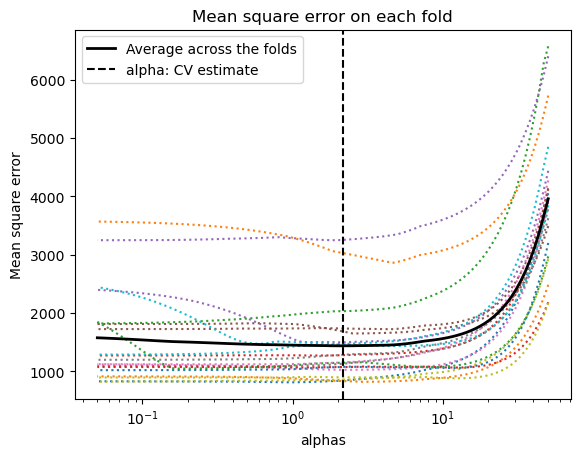

In [55]:
plt.semilogx(model.alphas_, model.mse_path_, ":")
plt.plot(
    model.alphas_ ,
    model.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight")